In [2]:
# Import necessary packages
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature
import skimage.data

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(2021, 62, 47)

In [4]:
from skimage import data, transform
imgs_to_use = ['camera', 'text', 'coins', 'moon',
              'page', 'clock', 'immunohistochemistry',
              'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
         for name in imgs_to_use]
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img, N, scale=1.0,
                   patch_size=positive_patches[0].shape):
    extracted_patch_size = \
    tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                              max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                           for patch in patches])
    return patches
negative_patches = np.vstack([extract_patches(im, 1000, scale)
                             for im in images for scale in 
                             [0.5, 1.0, 2.0]])
negative_patches.shape

c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(30000, 62, 47)

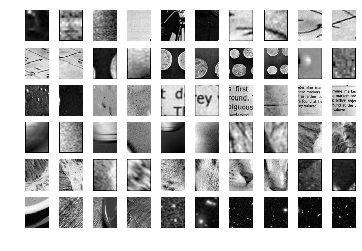

In [5]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

In [6]:
from itertools import chain
X_train = np.array([feature.hog(im)
                   for im in chain(positive_patches,
                                  negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
X_train.shape

c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(32021, 1215)

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


array([0.96327525, 0.92167885, 0.9683313 ])

In [8]:
from sklearn.svm import LinearSVC
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(LinearSVC(), {'C':[1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


0.9939102464007995

In [9]:
grid.best_params_

{'C': 2.0}

In [10]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(152, 110)


(-0.5, 89.5, 151.5, -0.5)

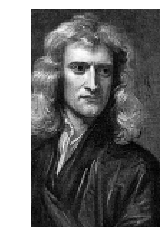

In [11]:
import cv2
test_image = cv2.imread('Newton.jpg')
#test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
print(test_image.shape)
test_image = test_image[:160, 20:180]
#test_image = test_image[:500, 100:900]

plt.imshow(test_image, cmap='gray')
plt.axis('off')

In [12]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                  istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
        
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

c:\users\tony jiang\appdata\local\programs\python\python35\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


(630, 1215)

In [13]:
labels = model.predict(patches_hog)
labels.sum()

15.0

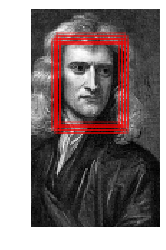

In [14]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                              alpha=0.3, lw=2,
                              facecolor='none'))